Hi Welcome to Risk Analyst - Lending Club!
Pada project ini saya akan mencari tahu Risiko apa saja yang bisa ditangani dari kasus Lending Club dengan dataset Lending Club.

Dataset ini berisi informasi mengenai pinjaman oleh kustomer, mulai dari jenis pinjaman hingga profil customer.


Pada analisis ini kita akan mengimplementasikan materi dari course "Information System Auditing - Coursera"

Dalam Risk Management ada 3 hal yang perlu diperhatikan yaitu:
* Risk Assesment
* Risk Mitigation
* Risk Re-Evaluation

'Pada saat notebook ini pertamakali dibuat saya masih dalam belajar Risk Management, bila ada kesalahan dalam pemahaman mohon berikan feedback langsung pada comment. Terimakasih

**Objective**
* Membagi kriteria risiko **Lending** client.
* Memberikan rekomendasi mitigasi **Pinjaman**.
* Membuat prediksi client yang memiliki bad loan.

# Install & Import Library

In [1]:
pip install chart_studio

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Import our libraries we are going to use for our data analysis.
import tensorflow as tf
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime

# Plotly visualizations
from plotly import tools
import chart_studio.plotly as py
import plotly.figure_factory as ff
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
# plotly.tools.set_credentials_file(username='AlexanderBach', api_key='o4fx6i1MtEIJQxfWYvU1')


# For oversampling Library (Dealing with Imbalanced Datasets)
from imblearn.over_sampling import SMOTE
from collections import Counter

# Other Libraries
import time


%matplotlib inline

/opt/conda/lib/python3.7/site-packages/geopandas/_compat.py:115: UserWarning:

The Shapely GEOS version (3.9.1-CAPI-1.14.2) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.



# Import Data

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/lending-club-dataset/lending_club_loan_two.csv


In [4]:
pd.set_option('display.float', '{:.2f}'.format)
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)

# Data Description

In [5]:
df = pd.read_csv('/kaggle/input/lending-club-dataset/lending_club_loan_two.csv')

In [6]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,Jan-2015,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690"
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,Jan-2015,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113"
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,Jan-2015,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113"
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,Nov-2014,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813"
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,Apr-2013,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650"


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 396030 entries, 0 to 396029
Data columns (total 27 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   loan_amnt             396030 non-null  float64
 1   term                  396030 non-null  object 
 2   int_rate              396030 non-null  float64
 3   installment           396030 non-null  float64
 4   grade                 396030 non-null  object 
 5   sub_grade             396030 non-null  object 
 6   emp_title             373103 non-null  object 
 7   emp_length            377729 non-null  object 
 8   home_ownership        396030 non-null  object 
 9   annual_inc            396030 non-null  float64
 10  verification_status   396030 non-null  object 
 11  issue_d               396030 non-null  object 
 12  loan_status           396030 non-null  object 
 13  purpose               396030 non-null  object 
 14  title                 394275 non-null  object 
 15  

# 1. Membagi kriteria risiko Loan

In [8]:
df['loan_status'].value_counts()

Fully Paid     318357
Charged Off     77673
Name: loan_status, dtype: int64

<AxesSubplot:title={'center':'Perbandingan status Pinjaman'}, ylabel='loan_status'>

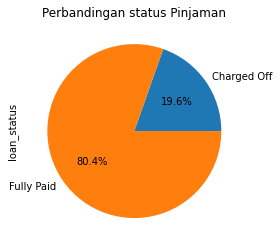

In [9]:
plt.title('Perbandingan status Pinjaman')
df['loan_status'].value_counts().sort_values().plot(kind = 'pie', autopct='%1.1f%%')

**Insight** : Setidaknya dari data ini, sebagian besar berhasil dibayar, dan kurang dari 20%  client default.

<AxesSubplot:title={'center':'Jumlah Pinjaman'}, xlabel='loan_amnt', ylabel='Count'>

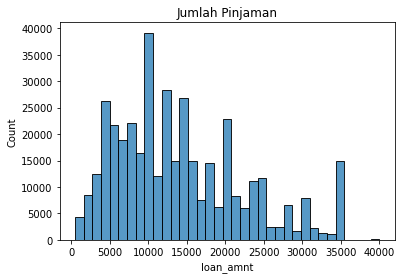

In [10]:
plt.title('Jumlah Pinjaman')
sns.histplot(df, x="loan_amnt", bins=35)

<AxesSubplot:title={'center':'Jumlah Angsuran'}, xlabel='installment', ylabel='Count'>

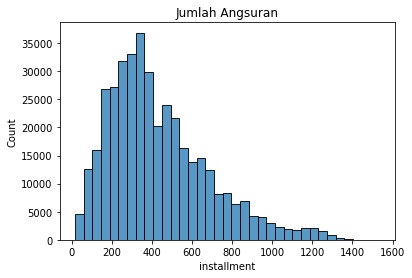

In [11]:
plt.title('Jumlah Angsuran')
sns.histplot(df, x="installment", bins=35)

In [12]:
df['issue_d'] = pd.to_datetime(df['issue_d'])

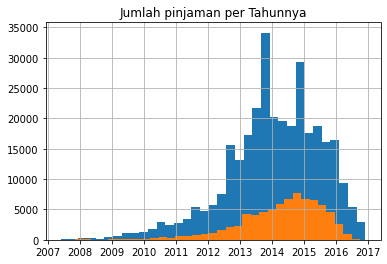

In [13]:
plt.title('Jumlah pinjaman per Tahunnya')
fully_paid = df.loc[df['loan_status']=='Fully Paid', 'issue_d'].hist(bins=35) 
charged_off = df.loc[df['loan_status']=='Charged Off', 'issue_d'].hist(bins=35)

**Insight** : Dari tahun 2009 hingga 2014 terlihat **perkembangan** yang signifikan dari jumlah pinjaman, kemudian dari tahun itu juga terjadi **penurunan**.

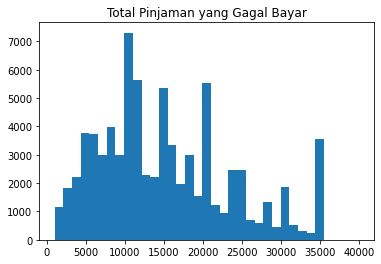

In [14]:
plt.title('Total Pinjaman yang Gagal Bayar')
charged_off = df.loc[df['loan_status']=='Charged Off', 'loan_amnt'].hist(bins=35, grid=False)

## Risk by Region

In [15]:
df['zip_code'] = df.address.apply(lambda x: x[-8:])
df['zip_code']

0         OK 22690
1         SD 05113
2         WV 05113
3         MA 00813
4         VA 11650
            ...   
396025    DC 30723
396026    LA 05113
396027    NY 70466
396028    FL 29597
396029    AR 48052
Name: zip_code, Length: 396030, dtype: object

In [16]:
df['zip_cd'] = df.zip_code.apply(lambda x: x[-5:])
df['zip_cd']

0         22690
1         05113
2         05113
3         00813
4         11650
          ...  
396025    30723
396026    05113
396027    70466
396028    29597
396029    48052
Name: zip_cd, Length: 396030, dtype: object

In [17]:
df['region'] = df.zip_code.apply(lambda x: x[:2])
df['region'] 

0         OK
1         SD
2         WV
3         MA
4         VA
          ..
396025    DC
396026    LA
396027    NY
396028    FL
396029    AR
Name: region, Length: 396030, dtype: object

In [18]:
df['region'].value_counts()

AP    14308
AE    14157
AA    13919
NJ     7091
WI     7081
      ...  
DC     6842
NM     6842
PA     6825
NH     6818
KY     6800
Name: region, Length: 54, dtype: int64

In [19]:
# Plotting by states

# Grouping by our metrics
# First Plotly Graph (We evaluate the operative side of the business)
by_loan_amount = df.groupby(['region','zip_cd'], as_index=False).loan_amnt.sum()
by_interest_rate = df.groupby(['region', 'zip_cd'], as_index=False).int_rate.mean()
by_income = df.groupby(['region', 'zip_cd'], as_index=False).annual_inc.mean()



# Take the values to a list for visualization purposes.
states = by_loan_amount['region'].values.tolist()
average_loan_amounts = by_loan_amount['loan_amnt'].values.tolist()
average_interest_rates = by_interest_rate['int_rate'].values.tolist()
average_annual_income = by_income['annual_inc'].values.tolist()


from collections import OrderedDict

# Figure Number 1 (Perspective for the Business Operations)
metrics_data = OrderedDict([('state_codes', states),
                            ('issued_loans', average_loan_amounts),
                            ('interest_rate', average_interest_rates),
                            ('annual_income', average_annual_income)])
                     

metrics_df = pd.DataFrame.from_dict(metrics_data)
metrics_df = metrics_df.round(decimals=2)
metrics_df.head()



# Think of a way to add default rate
# Consider adding a few more metrics for the future

,state_codes,issued_loans,interest_rate,annual_income
0,AA,22531025.00,12.90,79877.31
1,AA,22983350.00,13.12,75585.58
2,AA,5915050.00,16.11,69318.46
3,AA,28573875.00,13.58,73595.77
4,AA,21265375.00,13.14,73614.64


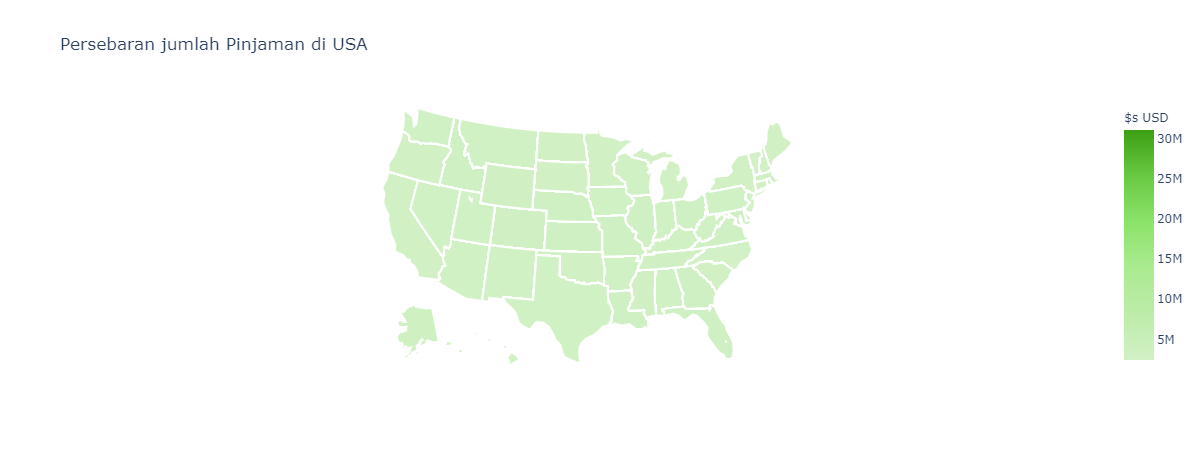

In [20]:
# Now it comes the part where we plot out plotly United States map
#import plotly.plotly as py
import plotly.graph_objs as go


for col in metrics_df.columns:
    metrics_df[col] = metrics_df[col].astype(str)
    
scl = [[0.0, 'rgb(210, 241, 198)'],[0.2, 'rgb(188, 236, 169)'],[0.4, 'rgb(171, 235, 145)'],\
            [0.6, 'rgb(140, 227, 105)'],[0.8, 'rgb(105, 201, 67)'],[1.0, 'rgb(59, 159, 19)']]

metrics_df['text'] = metrics_df['state_codes'] + '<br>' +\
'Average loan interest rate: ' + metrics_df['interest_rate'] + '<br>'+\
'Average annual income: ' + metrics_df['annual_income'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = metrics_df['state_codes'],
        z = metrics_df['issued_loans'], 
        locationmode = 'USA-states',
        text = metrics_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "$s USD")
        ) ]


layout = dict(
    title = 'Persebaran jumlah Pinjaman di USA',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

* **Insight** : Tidak ada perbedaan **Signifikan** dari persebaran jumlah pinjaman di USA. 

## Risk by Income

In this section we will create different categories of **Income** from:
* Low    : Is under 45.000 usd per year
* Medium : is between 45.000 usd per year and 65.000 usd per year
* High   : is more than 65.000 usd per year

In [21]:
bins= [-np.inf,45000,150000, np.inf]
labels = ['low','medium','high']
df['income_category'] = pd.cut(df['annual_inc'], bins=bins, labels=labels, right=False)
df['income_category']

0         medium
1         medium
2            low
3         medium
4         medium
           ...  
396025       low
396026    medium
396027    medium
396028    medium
396029       low
Name: income_category, Length: 396030, dtype: category
Categories (3, object): ['low' < 'medium' < 'high']

In [22]:
df['income_category'].value_counts()

medium    283023
low        91204
high       21803
Name: income_category, dtype: int64

In [23]:
#loan_status to numeric
def renovated(df) : 
    if df["loan_status"] == 'Charged Off' : 
        return 1
    else :
        return 0

    
df["loan_status_int"] = df.apply(renovated, axis =1 )

In [24]:
df['emp_length'].unique()

array(['10+ years', '4 years', '< 1 year', '6 years', '9 years',
       '2 years', '3 years', '8 years', '7 years', '5 years', '1 year',
       nan], dtype=object)

In [25]:
#merubah emp_length menjadi angka saja
def renovated(df) : 
    if df["emp_length"] == '< 1 year' : 
        return 0
    if df["emp_length"] == '1 year' : 
        return 1
    if df["emp_length"] == '2 years' : 
        return 2
    if df["emp_length"] == '3 years' : 
        return 3
    if df["emp_length"] == '4 years' : 
        return 4
    if df["emp_length"] == '5 years' : 
        return 5
    if df["emp_length"] == '6 years' : 
        return 6
    if df["emp_length"] == '7 years' : 
        return 8
    if df["emp_length"] == '9 years' : 
        return 9
    else :
        return 10

    
df["emp_length_int"] = df.apply(renovated, axis =1 )
df["emp_length_int"].value_counts()

10    163510
2      35827
0      31725
3      31665
5      26495
1      25882
4      23952
6      20841
8      20819
9      15314
Name: emp_length_int, dtype: int64

<AxesSubplot:xlabel='income_category', ylabel='int_rate'>

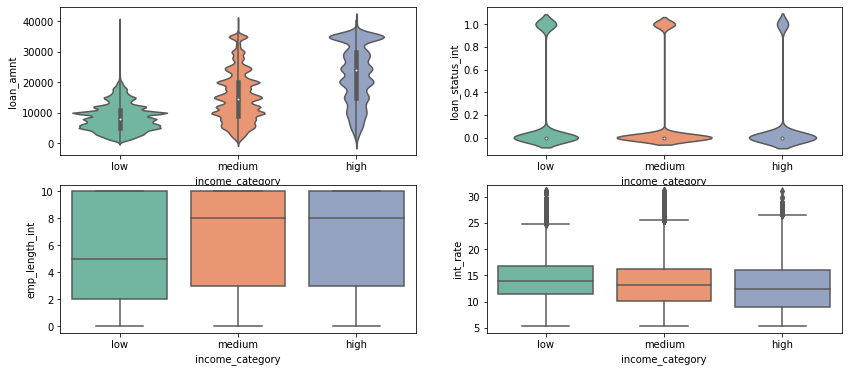

In [26]:
fig, ((ax1, ax2), (ax3, ax4))= plt.subplots(nrows=2, ncols=2, figsize=(14,6))

# Change the Palette types tomorrow!

sns.violinplot(x="income_category", y="loan_amnt", data=df, palette="Set2", ax=ax1 )
sns.violinplot(x="income_category", y="loan_status_int", data=df, palette="Set2", ax=ax2)
sns.boxplot(x="income_category", y="emp_length_int", data=df, palette="Set2", ax=ax3)
sns.boxplot(x="income_category", y="int_rate", data=df, palette="Set2", ax=ax4)

**Insigth**
* based on loan amount, there **low income** have loan amount is about **10.000 usd**, then the **medium** have **high varieance**, last for **high income** have a bold amount in **35.000 usd** 
* for the the status loan, three of categories have **same** of total for the **loan_status**
* the the employment theres have **same** of years, for the all of income category.
* and last for interest rate, that is interesting is **more high income is more moderate**, that for **low income** , the average is about 14%, mean they more likely to take the **high risk** for they'r self.
* There's nothing what cause about **Bad Loan**

## Analyze the Risky for Business

In [27]:
by_condition = df.groupby('region')['loan_status'].value_counts()/ df.groupby('region')['loan_status'].count()
by_emp_length = df.groupby(['region'], as_index=False).emp_length_int.mean().sort_values(by="region")

loan_condition_bystate = pd.crosstab(df['region'], df['loan_status'] )

cross_condition = pd.crosstab(df["region"], df["loan_status"])
# Percentage of condition of loan
percentage_loan_contributor = pd.crosstab(df['region'], df['loan_status']).apply(lambda x: x/x.sum() * 100)
condition_ratio = cross_condition["Charged Off"]/cross_condition["Fully Paid"]
by_dti = df.groupby(['region'], as_index=False).dti.mean()
state_codes = sorted(df['region'].unique())


# Take to a list
default_ratio = condition_ratio.values.tolist()
average_dti = by_dti['dti'].values.tolist()
average_emp_length = by_emp_length["emp_length_int"].values.tolist()
number_of_badloans = loan_condition_bystate['Charged Off'].values.tolist()
percentage_ofall_badloans = percentage_loan_contributor['Charged Off'].values.tolist()


# Figure Number 2
risk_data = OrderedDict([('state_codes', state_codes),
                         ('default_ratio', default_ratio),
                         ('badloans_amount', number_of_badloans),
                         ('percentage_of_badloans', percentage_ofall_badloans),
                         ('average_dti', average_dti),
                         ('average_emp_length', average_emp_length)])


# Figure 2 Dataframe 
risk_df = pd.DataFrame.from_dict(risk_data)
risk_df = risk_df.round(decimals=3)
risk_df.head()

,state_codes,default_ratio,badloans_amount,percentage_of_badloans,average_dti,average_emp_length
0,AA,0.24,2711,3.49,17.37,6.28
1,AE,0.24,2763,3.56,17.38,6.29
2,AK,0.25,1390,1.79,17.48,6.26
3,AL,0.24,1348,1.74,17.36,6.20
4,AP,0.25,2873,3.70,17.52,6.28


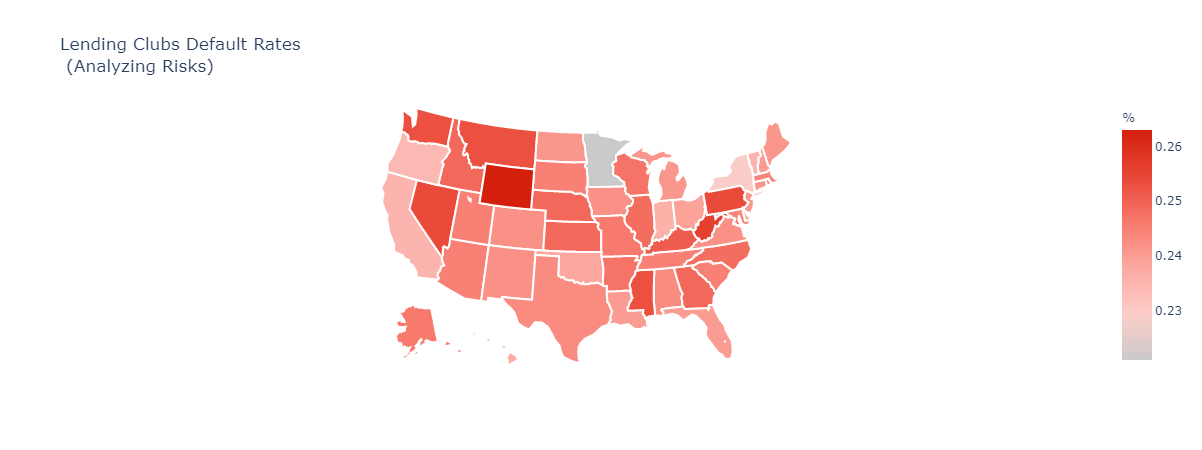

In [28]:
# Now it comes the part where we plot out plotly United States map
#import plotly.plotly as py
import plotly.graph_objs as go


for col in risk_df.columns:
    risk_df[col] = risk_df[col].astype(str)
    
scl = [[0.0, 'rgb(202, 202, 202)'],[0.2, 'rgb(253, 205, 200)'],[0.4, 'rgb(252, 169, 161)'],\
            [0.6, 'rgb(247, 121, 108  )'],[0.8, 'rgb(232, 70, 54)'],[1.0, 'rgb(212, 31, 13)']]

risk_df['text'] = risk_df['state_codes'] + '<br>' +\
'Number of Bad Loans: ' + risk_df['badloans_amount'] + '<br>' + \
'Percentage of all Bad Loans: ' + risk_df['percentage_of_badloans'] + '%' +  '<br>' + \
'Average Debt-to-Income Ratio: ' + risk_df['average_dti'] + '<br>'+\
'Average Length of Employment: ' + risk_df['average_emp_length'] 


data = [ dict(
        type='choropleth',
        colorscale = scl,
        autocolorscale = False,
        locations = risk_df['state_codes'],
        z = risk_df['default_ratio'], 
        locationmode = 'USA-states',
        text = risk_df['text'],
        marker = dict(
            line = dict (
                color = 'rgb(255,255,255)',
                width = 2
            ) ),
        colorbar = dict(
            title = "%")
        ) ]


layout = dict(
    title = 'Lending Clubs Default Rates <br> (Analyzing Risks)',
    geo = dict(
        scope = 'usa',
        projection=dict(type='albers usa'),
        showlakes = True,
        lakecolor = 'rgb(255, 255, 255)')
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='d3-cloropleth-map')

**Insight** : From the map, that we can see the default ration from every region is **very risky**. That most likely **more than 0.25**

## Credit Score vs Lending Risk

In [29]:
df['issue_d']

0        2015-01-01
1        2015-01-01
2        2015-01-01
3        2014-11-01
4        2013-04-01
            ...    
396025   2015-10-01
396026   2015-02-01
396027   2013-10-01
396028   2012-08-01
396029   2010-06-01
Name: issue_d, Length: 396030, dtype: datetime64[ns]

In [30]:
df['issue_year'] = df['issue_d'].dt.strftime('%Y')

print(df['issue_year'])

0         2015
1         2015
2         2015
3         2014
4         2013
          ... 
396025    2015
396026    2015
396027    2013
396028    2012
396029    2010
Name: issue_year, Length: 396030, dtype: object


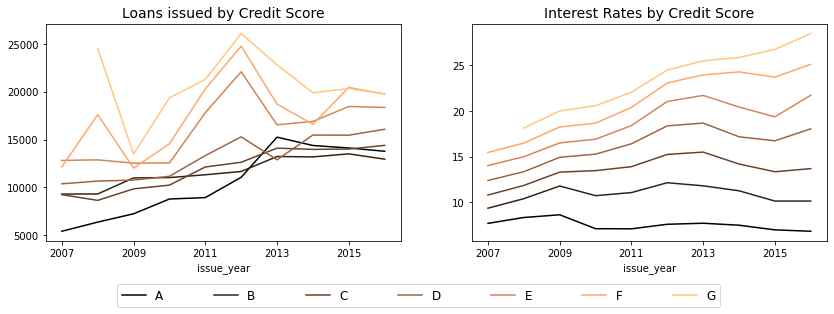

In [31]:
# Let's visualize how many loans were issued by creditscore
f, ((ax1, ax2)) = plt.subplots(1, 2)
cmap = plt.cm.copper

by_credit_score = df.groupby(['issue_year', 'grade']).loan_amnt.mean()
by_credit_score.unstack().plot(legend=False, ax=ax1, figsize=(14, 4), colormap=cmap)
ax1.set_title('Loans issued by Credit Score', fontsize=14)
    
    
by_inc = df.groupby(['issue_year', 'grade']).int_rate.mean()
by_inc.unstack().plot(ax=ax2, figsize=(14, 4), colormap=cmap)
ax2.set_title('Interest Rates by Credit Score', fontsize=14)

ax2.legend(bbox_to_anchor=(-1.0, -0.3, 1.7, 0.1), loc=5, prop={'size':12},
           ncol=7, mode="expand", borderaxespad=0.)

In [32]:
df.groupby(['issue_year']).issue_year.count()

issue_year
2007       195
2008      1240
2009      3826
2010      9258
2011     17435
2012     41202
2013     97662
2014    102860
2015     94264
2016     28088
Name: issue_year, dtype: int64

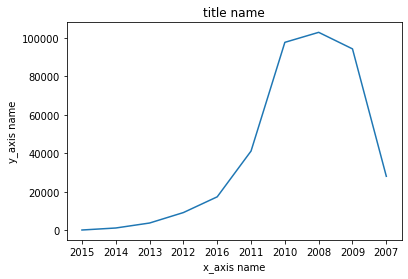

In [33]:
x_axis = df['issue_year'].unique()
y_axis = df.groupby(['issue_year']).issue_year.count()

plt.plot(x_axis, y_axis)
plt.title('title name')
plt.xlabel('x_axis name')
plt.ylabel('y_axis name')
plt.show()

**Insight**
* Based on the sum of loan, more **smaller** the Grade then loan amount will more **stable**.
* Based on the interest rates, More **bigger** the **Grade** then the **interest** more **biggger**, even 'A' Grade taking more smaller interest rate.

Text(0, 0.5, 'Interest Rate (%)')

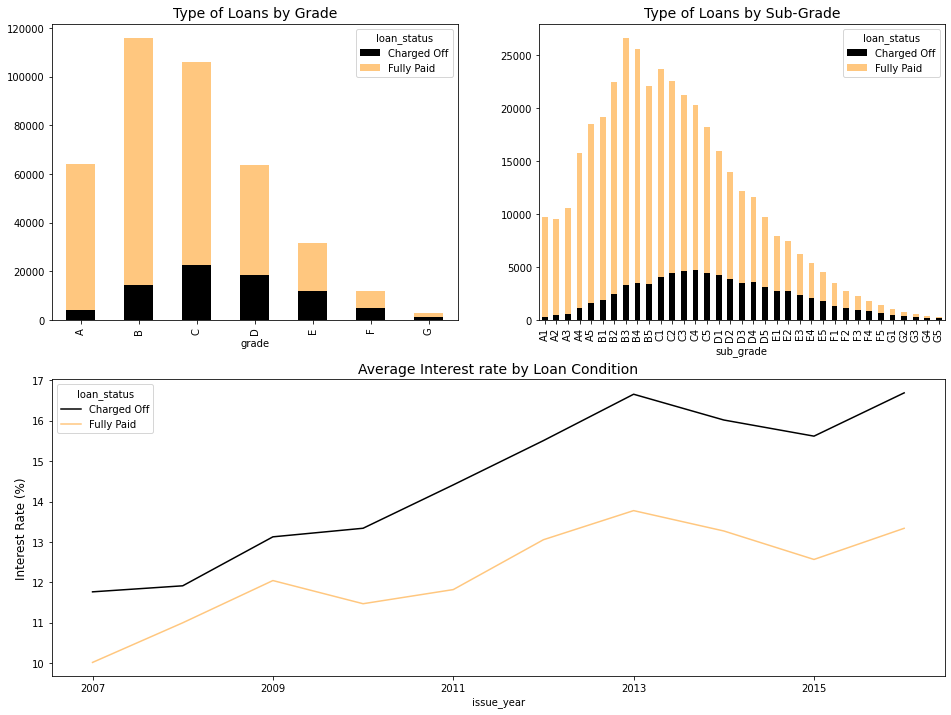

In [34]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(212)

cmap = plt.cm.copper

loans_by_region = df.groupby(['grade', 'loan_status']).size()
loans_by_region.unstack().plot(kind='bar', stacked=True, colormap=cmap, ax=ax1, grid=False)
ax1.set_title('Type of Loans by Grade', fontsize=14)


loans_by_grade = df.groupby(['sub_grade', 'loan_status']).size()
loans_by_grade.unstack().plot(kind='bar', stacked=True, colormap=cmap,
                              ax=ax2, grid=False)
ax2.set_title('Type of Loans by Sub-Grade', fontsize=14)

by_interest = df.groupby(['issue_year', 'loan_status']).int_rate.mean()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Average Interest rate by Loan Condition', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

**Insight**
* As we can see, every year, **interest rate more bigger** after year.
* Then the Grade that have **highest Interest Rate is B**, but the most have **Default is in Grade C**.

## Defaulted loans and Level of Risk

We assume the high Interest Rate is above 13.64% from the average of Interest rate, and low interest rate is belom 13.64%.

In [35]:
df['int_rate'].describe()

count   396030.00
mean        13.64
std          4.47
min          5.32
25%         10.49
50%         13.33
75%         16.49
max         30.99
Name: int_rate, dtype: float64

In [36]:
def renovated(df) : 
    if df["int_rate"] <= 13.64 : 
        return 0
    else :
        return 1

    
df["int_cat"] = df.apply(renovated, axis =1 )
df['int_cat'].head()

0    0
1    0
2    0
3    0
4    1
Name: int_cat, dtype: int64

In [37]:
df['term'].value_counts()

 36 months    302005
 60 months     94025
Name: term, dtype: int64

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



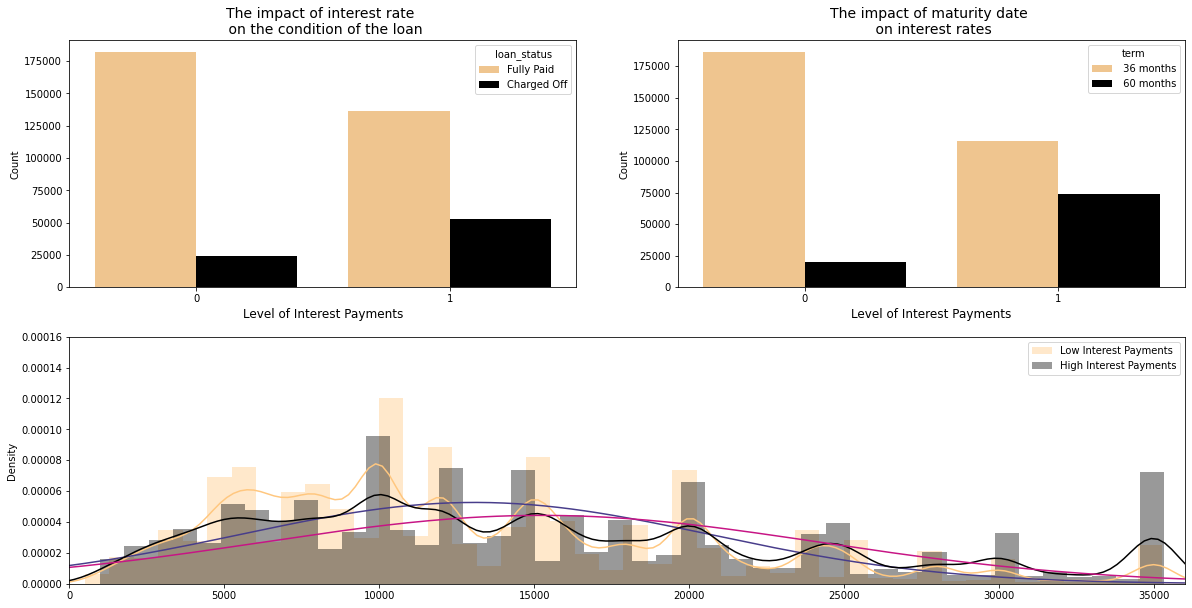

In [38]:
from scipy.stats import norm

plt.figure(figsize=(20,10))

palette = ['#FFC77F', '#000000']
plt.subplot(221)
ax = sns.countplot(x='int_cat', data=df, 
                  palette=palette, hue='loan_status')

ax.set_title('The impact of interest rate \n on the condition of the loan', fontsize=14)
ax.set_xlabel('Level of Interest Payments', fontsize=12)
ax.set_ylabel('Count')

plt.subplot(222)
ax1 = sns.countplot(x='int_cat', data=df, 
                   palette=palette, hue='term')


ax1.set_title('The impact of maturity date \n on interest rates', fontsize=14)
ax1.set_xlabel('Level of Interest Payments', fontsize=12)
ax1.set_ylabel('Count')


plt.subplot(212)
low = df['loan_amnt'].loc[df['int_cat'] == 0].values
high = df['loan_amnt'].loc[df['int_cat'] == 1].values


ax2= sns.distplot(low, color='#FFC77F', label='Low Interest Payments', fit=norm, fit_kws={"color":"#483d8b"}) # Dark Blue Norm Color
ax3 = sns.distplot(high, color='#000000', label='High Interest Payments', fit=norm, fit_kws={"color":"#c71585"}) #  Red Norm Color
plt.axis([0, 36000, 0, 0.00016])
plt.legend()

plt.show()

**Insight**:
* Dari grafik diatas kita dapat pahami bahwa **Interest rate tinggi** lebih menyebabkan **Default**
* Juga untuk **Maturity yang lebih panjang** lebih sering terjadi **Default**.

## Condition of Loan and Purpose:

**Key point**:
* Average interest by income category and purposes 
* Which purpose carries a higher interest rate and does income category have an influence on risk?
* Is LendingClub deploying loan amount where there is a high risk (interest_rate)
* Remember we learned that interest_rates is a key metric in evaluating risk.


In [39]:
df['purpose'].value_counts()

debt_consolidation    234507
credit_card            83019
home_improvement       24030
other                  21185
major_purchase          8790
small_business          5701
car                     4697
medical                 4196
moving                  2854
vacation                2452
house                   2201
wedding                 1812
renewable_energy         329
educational              257
Name: purpose, dtype: int64

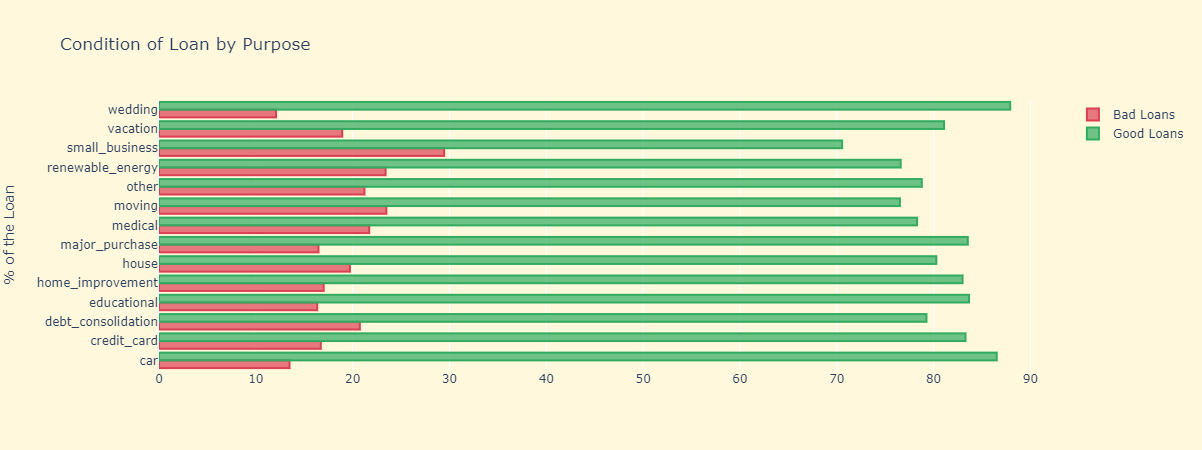

In [40]:
df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(df['loan_status'], df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

purpose_bad_loans = purpose_condition.values[0].tolist()
purpose_good_loans = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=purpose_bad_loans,
    y=purpose,
    orientation='h',
    name = 'Bad Loans',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=purpose_good_loans,
    y=purpose,
    orientation='h',
    name='Good Loans',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

In [41]:

group_income_purpose = df.groupby(['income_category', 'purpose'], as_index=False).int_rate.mean()
group_dti_purpose = df.groupby(['income_category', 'purpose'], as_index=False).loan_amnt.mean()
loan_a = group_dti_purpose['loan_amnt'].values



# High Car 10.32 15669
new_groupby = group_income_purpose.assign(total_loan_amount=loan_a)
sort_group_income_purpose = new_groupby.sort_values(by="income_category", ascending=True)

In [42]:
loan_count = df.groupby(['income_category', 'purpose'])['loan_status'].apply(lambda x: x.value_counts())
d={"loan_c": loan_count}
loan_c_df = pd.DataFrame(data=d).reset_index()
loan_c_df = loan_c_df.rename(columns={"level_2": "loan_status"})


# Good loans & Bad Loans
good_loans = loan_c_df.loc[loan_c_df['loan_status'] == "Fully Paid"].sort_values(by="income_category", ascending=True)
bad_loans = loan_c_df.loc[loan_c_df['loan_status'] == "Charged Off"].sort_values(by="income_category", ascending=True)
sort_group_income_purpose['good_loans_count'] = good_loans['loan_c'].values
sort_group_income_purpose['bad_loans_count'] = bad_loans['loan_c'].values
sort_group_income_purpose['total_loans_issued'] = (good_loans['loan_c'].values + bad_loans['loan_c'].values)

sort_group_income_purpose['bad/good ratio (%)'] = np.around(bad_loans['loan_c'].values / (bad_loans['loan_c'].values + good_loans['loan_c'].values), 4) * 100
final_df = sort_group_income_purpose.sort_values(by='income_category', ascending=True)
final_df.style.background_gradient('coolwarm')

,income_category,purpose,int_rate,total_loan_amount,good_loans_count,bad_loans_count,total_loans_issued,bad/good ratio (%)
0,low,car,12.612027,5994.983165,1224,261,1485,17.580000
6,low,major_purchase,13.246029,6753.826531,1791,463,2254,20.540000
1,low,credit_card,13.026056,8854.637775,15118,4207,19325,21.770000
2,low,debt_consolidation,14.332019,9043.412293,39552,13471,53023,25.410000
4,low,home_improvement,13.688029,7942.852142,2825,746,3571,20.890000
5,low,house,16.093277,8871.670190,360,113,473,23.890000
10,low,renewable_energy,15.086346,6132.211538,75,29,104,27.880000
3,low,educational,11.691418,4854.078014,115,26,141,18.440000
8,low,moving,15.826233,4968.095238,667,278,945,29.420000
9,low,other,15.530371,6135.433224,4786,1631,6417,25.420000


/opt/conda/lib/python3.7/site-packages/plotly/tools.py:464: DeprecationWarning:

plotly.tools.make_subplots is deprecated, please use plotly.subplots.make_subplots instead



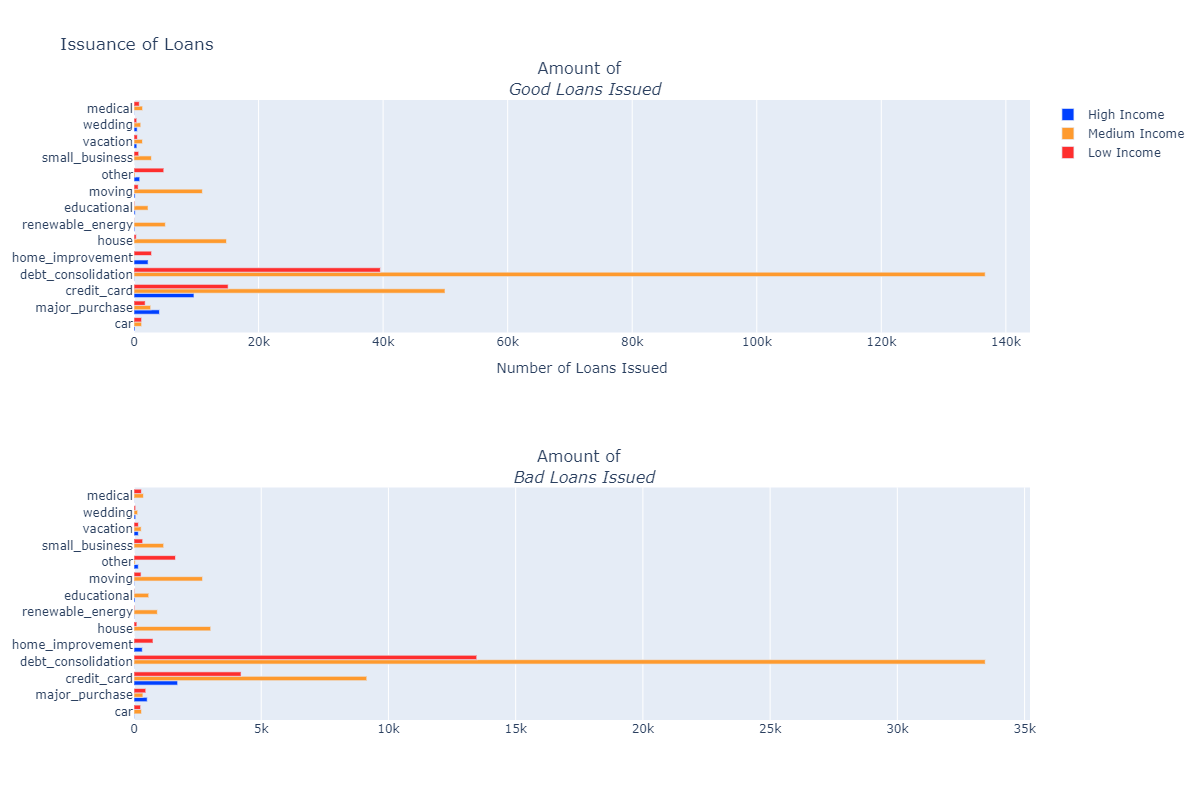

In [43]:
# Labels
purpose_labels = final_df['purpose'].unique()

# Amount of Good and Bad Loans per Purpose (fill by income category)
# Good Loans
good_high_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "high"].values.tolist()
good_med_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "medium"].values.tolist()
good_low_cnt = final_df['good_loans_count'].loc[final_df['income_category'] == "low"].values.tolist()

# Bad Loans
bad_high_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "high"].values.tolist()
bad_med_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "medium"].values.tolist()
bad_low_cnt = final_df['bad_loans_count'].loc[final_df['income_category'] == "low"].values.tolist()


# Good Loans
trace0 = go.Bar(
    y=purpose_labels,
    x=good_high_cnt,
    legendgroup='a',
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace1 = go.Bar(
    x=good_med_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace2 = go.Bar(
    x=good_low_cnt,
    y=purpose_labels,
    legendgroup='a',
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)

# Bad Loans issued by Income Category
trace3 = go.Bar(
    y=purpose_labels,
    x=bad_high_cnt,
    legendgroup='b',
    showlegend=False,
    name='High Income',
    orientation='h', 
    marker=dict(
        color='#0040FF'
    )
)
trace4 = go.Bar(
    x=bad_med_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Medium Income',
    orientation='h',
    marker=dict(
        color='#FE9A2E',
    )
)

trace5 = go.Bar(
    x=bad_low_cnt,
    y=purpose_labels,
    legendgroup='b',
    showlegend=False,
    name='Low Income',
    orientation='h',
    marker=dict(
        color='#FE2E2E',
    )
)



fig = tools.make_subplots(rows=2, cols=1, print_grid=False,
                         subplot_titles=("Amount of <br> <i>Good Loans Issued</i>",
                                        "Amount of <br> <i>Bad Loans Issued</i>")
                         )

# First Subplot
fig.append_trace(trace0, 1, 1)
fig.append_trace(trace1, 1, 1)
fig.append_trace(trace2, 1, 1)

# Second Subplot
fig.append_trace(trace3, 2, 1)
fig.append_trace(trace4, 2, 1)
fig.append_trace(trace5, 2, 1)

fig['layout'].update(height=800, width=800, title='Issuance of Loans', showlegend=True, xaxis=dict(title="Number of Loans Issued"))
iplot(fig, filename='angled-text-bar')

## Lossess incuries

In [44]:
loss_df = df.loc[df['loan_status'] == 'Charged Off']
loss_df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,zip_code,zip_cd,region,income_category,loan_status_int,emp_length_int,issue_year,int_cat
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,2013-04-01,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650",VA 11650,11650,VA,medium,1,9,2013,1
25,6000.00,36 months,11.36,197.47,B,B5,CSU Monterey Bay,2 years,RENT,46680.00,Not Verified,2010-04-01,Charged Off,medical,Medical and Post Graduate Education Expenses,6.56,Oct-2003,9.00,0.00,4370.00,40.10,10.00,f,INDIVIDUAL,NaN,0.00,"44130 Powers Course Suite 880\r\nEast Preston,...",AZ 30723,30723,AZ,medium,1,2,2010,0
26,8400.00,36 months,13.35,284.45,C,C2,Bartender,6 years,RENT,35000.00,Source Verified,2014-06-01,Charged Off,debt_consolidation,Debt consolidation,23.08,Jun-2004,6.00,0.00,6953.00,74.80,17.00,f,INDIVIDUAL,0.00,0.00,Unit 3166 Box 1862\r\nDPO AE 48052,AE 48052,48052,AE,low,1,6,2014,0
36,3250.00,36 months,16.78,115.52,C,C5,NaN,NaN,RENT,22500.00,Verified,2013-08-01,Charged Off,debt_consolidation,Cover,18.76,Jun-2009,7.00,0.00,7587.00,54.60,7.00,f,INDIVIDUAL,0.00,0.00,"361 Erica Forest\r\nLake Mariaton, TN 30723",TN 30723,30723,TN,low,1,10,2013,1
41,28000.00,60 months,19.91,312.04,E,E4,American Airlines,10+ years,RENT,52000.00,Verified,2011-12-01,Charged Off,debt_consolidation,Debt Consalidation,20.70,Dec-1988,10.00,0.00,29178.00,87.60,16.00,f,INDIVIDUAL,NaN,0.00,"5836 Garcia Falls Apt. 525\r\nMatthewtown, CT ...",CT 22690,22690,CT,medium,1,10,2011,1


Text(0.5, 1.0, 'Revolving utilize by Sub-Grade')

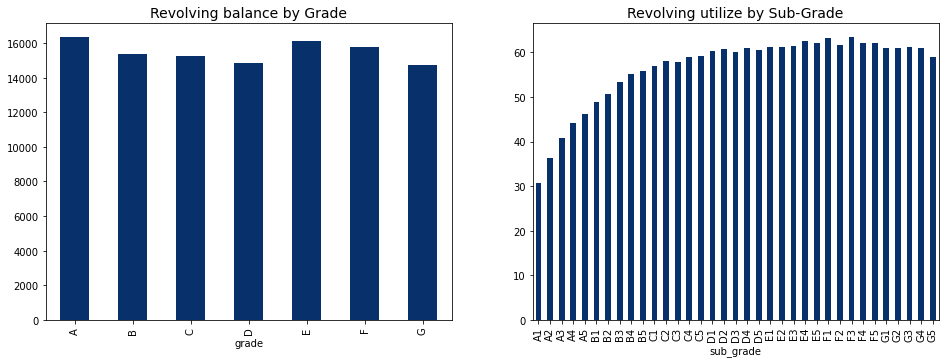

In [45]:
fig = plt.figure(figsize=(16,12))

ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)

#cmap = plt.Blue

loans_by_region = loss_df.groupby(['grade']).revol_bal.mean()
loans_by_region.plot(kind='bar', stacked=True, colormap='Blues_r', ax=ax1, grid=False)
ax1.set_title('Revolving balance by Grade', fontsize=14)


loans_by_grade = loss_df.groupby(['sub_grade']).revol_util.mean()
loans_by_grade.plot(kind='bar', stacked=True, colormap='Blues_r',
                              ax=ax2, grid=False)
ax2.set_title('Revolving utilize by Sub-Grade', fontsize=14)


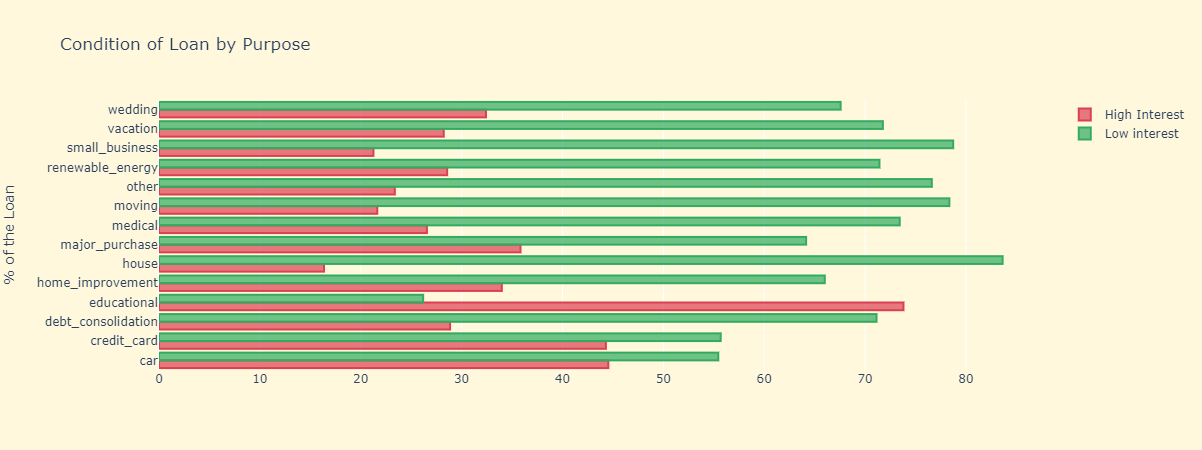

In [46]:
loss_df['purpose'].value_counts()

# Education, renewable energy, wedding are the purposed that contains highest bad loans percent wise.

purpose_condition = round(pd.crosstab(loss_df['int_cat'], loss_df['purpose']).apply(lambda x: x/x.sum() * 100), 2)

high_int = purpose_condition.values[0].tolist()
low_int = purpose_condition.values[1].tolist()
purpose = purpose_condition.columns


bad_plot = go.Bar(
    x=high_int,
    y=purpose,
    orientation='h',
    name = 'High Interest',
    text='%',
    marker=dict(
        color='rgba(219, 64, 82, 0.7)',
        line = dict(
            color='rgba(219, 64, 82, 1.0)',
            width=2
        )
    )
)

good_plot = go.Bar(
    x=low_int,
    y=purpose,
    orientation='h',
    name='Low interest',
    text='%',
    marker=dict(
        color='rgba(50, 171, 96, 0.7)',
        line = dict(
            color='rgba(50, 171, 96, 1.0)',
            width=2
        )
    )
)


data = [bad_plot, good_plot]

layout = go.Layout(
    title='Condition of Loan by Purpose',
    xaxis=dict(
        title=''
    ),
    yaxis=dict(
        title='% of the Loan',
    ),
    paper_bgcolor='#FFF8DC',
    plot_bgcolor='#FFF8DC',
    showlegend=True
)

fig = dict(data=data, layout=layout)
iplot(fig, filename='condition_purposes')

Text(0, 0.5, 'Interest Rate (%)')

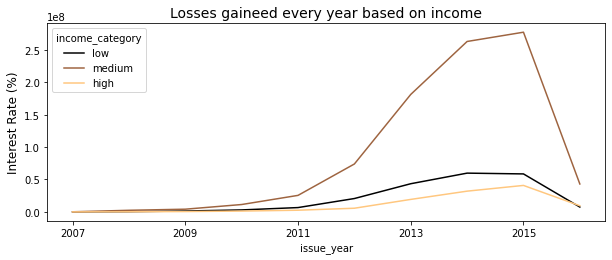

In [47]:
fig = plt.figure(figsize=(10,8))

ax3 = fig.add_subplot(212)

cmap = plt.cm.copper


by_interest = loss_df.groupby(['issue_year','income_category']).revol_bal.sum()
by_interest.unstack().plot(ax=ax3, colormap=cmap)
ax3.set_title('Losses gaineed every year based on income', fontsize=14)
ax3.set_ylabel('Interest Rate (%)', fontsize=12)

**Insight**
* In 2015 we have losess until **276.804.322 USD**
* From the purpose and interest rate, education have the same **loses**.
* And based the grade, there is no significant from each grade.

In [48]:
by_interest

issue_year  income_category
2007        low                   89630.00
            medium               245236.00
            high                  56411.00
2008        low                  467043.00
            medium              2551389.00
            high                 277685.00
2009        low                 1424319.00
            medium              4233949.00
            high                 614770.00
2010        low                 3124039.00
            medium             11432604.00
            high                1348746.00
2011        low                 6732209.00
            medium             25510020.00
            high                2650964.00
2012        low                20659609.00
            medium             73864377.00
            high                5715850.00
2013        low                43460061.00
            medium            180970957.00
            high               19306638.00
2014        low                59772422.00
            medium        

# Feature Engineering

Karena target data yang digunakan adalah categorical, kita tidak menggunakan corelational, tapi menggunakan Weight of Evidence dan Informational Value.

## Loan_status

In [49]:
def renovated(df) : 
    if  df['loan_status'] == 'Fully Paid': 
        return 0
    else :
        return 1

    
df["loan_status_int"] = df.apply(renovated, axis =1 )
df["loan_status_int"].value_counts()

0    318357
1     77673
Name: loan_status_int, dtype: int64

## 1. loan_amount

In [50]:
df['loan_amnt'].describe()

count   396030.00
mean     14113.89
std       8357.44
min        500.00
25%       8000.00
50%      12000.00
75%      20000.00
max      40000.00
Name: loan_amnt, dtype: float64

In [51]:
def renovated(df) : 
    if  df['loan_amnt'] <= 8000: 
        return 1
    elif df['loan_amnt'] <= 12000 :
        return 2
    elif df['loan_amnt'] <= 20000 :
        return 3
    else :
        return 4

    
df["loan_amnt_int"] = df.apply(renovated, axis =1)
df["loan_amnt_int"].value_counts()

1    112277
3    111020
2     91965
4     80768
Name: loan_amnt_int, dtype: int64

In [52]:
data_iv_1 = pd.crosstab(df["loan_amnt_int"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
loan_amnt_int,,,
1,18305,93972,112277
2,17231,74734,91965
3,23622,87398,111020
4,18515,62253,80768
Total,77673,318357,396030


In [53]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [54]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.025640168524960906

Loan_amnt_int is a weak feature

## 2. Income

In [55]:
df['income_category'].value_counts()

medium    283023
low        91204
high       21803
Name: income_category, dtype: int64

In [56]:
def renovated(df) : 
    if  df['income_category'] == 'low': 
        return 0
    elif df['income_category'] == 'medium': 
        return 1
    else :
        return 3

    
df["inc_cat_int"] = df.apply(renovated, axis =1)
df["inc_cat_int"].value_counts()

1    283023
0     91204
3     21803
Name: inc_cat_int, dtype: int64

In [57]:
data_iv_1 = pd.crosstab(df["inc_cat_int"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
inc_cat_int,,,
0,22098,69106,91204
1,52477,230546,283023
3,3098,18705,21803
Total,77673,318357,396030


In [58]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [59]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.028920511207299573

income was a weak predictor

In [60]:
df['annual_inc'].describe()

count    396030.00
mean      74203.18
std       61637.62
min           0.00
25%       45000.00
50%       64000.00
75%       90000.00
max     8706582.00
Name: annual_inc, dtype: float64

In [61]:
def renovated(df) : 
    if  df['annual_inc'] <= 45000: 
        return 0
    elif df['annual_inc'] <= 64000 :
        return 1
    elif df['annual_inc'] <= 90000 :
        return 2
    else :
        return 3

    
df["annual_inc_int"] = df.apply(renovated, axis =1)
df["annual_inc_int"].value_counts()

2    104104
0    101318
1     97823
3     92785
Name: annual_inc_int, dtype: int64

In [62]:
data_iv_1 = pd.crosstab(df["annual_inc_int"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
annual_inc_int,,,
0,24396,76922,101318
1,20406,77417,97823
2,18935,85169,104104
3,13936,78849,92785
Total,77673,318357,396030


In [63]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [64]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.044729963005387716

## Emp length

In [65]:
data_iv_1 = pd.crosstab(df["emp_length"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
emp_length,,,
1 year,5154,20728,25882
10+ years,23215,102826,126041
2 years,6924,28903,35827
3 years,6182,25483,31665
4 years,4608,19344,23952
5 years,5092,21403,26495
6 years,3943,16898,20841
7 years,4055,16764,20819
8 years,3829,15339,19168


In [66]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/305094)
def event(df) : 
    return (df[0]/72635)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [67]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.0020709076084233376

employment length is weak feature

## Int Rate

In [68]:
data_iv_1 = pd.crosstab(df["int_cat"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
int_cat,,,
0,24496,182003,206499
1,53177,136354,189531
Total,77673,318357,396030


In [69]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/305094)
def event(df) : 
    return (df[0]/72635)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [70]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.2892763822247705

Interest rate have medium predictor

## dti

In [71]:
df['dti'].describe()

count   396030.00
mean        17.38
std         18.02
min          0.00
25%         11.28
50%         16.91
75%         22.98
max       9999.00
Name: dti, dtype: float64

In [72]:
def renovated(df) : 
    if  df['dti'] <= 11.28: 
        return 0
    elif df['dti'] <= 16.91 :
        return 1
    elif df['dti'] <= 22.98 :
        return 2
    else :
        return 3

    
df["dti_int"] = df.apply(renovated, axis =1)
df["dti_int"].value_counts()

1    99153
0    99034
3    98955
2    98888
Name: dti_int, dtype: int64

In [73]:
data_iv_1 = pd.crosstab(df["dti_int"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
dti_int,,,
0,13857,85177,99034
1,16769,82384,99153
2,20079,78809,98888
3,26968,71987,98955
Total,77673,318357,396030


In [74]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [75]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.09629802396825476

dti a weak predictor

## issue_year

In [76]:
data_iv_1 = pd.crosstab(df["issue_year"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
issue_year,,,
2007,32,163,195
2008,196,1044,1240
2009,469,3357,3826
2010,1223,8035,9258
2011,2658,14777,17435
2012,6790,34412,41202
2013,15372,82290,97662
2014,23772,79088,102860
2015,23473,70791,94264


In [77]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [78]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.08197380639328752

issued_year was a weak predictor

## Grade

In [79]:
data_iv_1 = pd.crosstab(df["grade"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
grade,,,
A,4036,60151,64187
B,14587,101431,116018
C,22449,83538,105987
D,18338,45186,63524
E,11765,19723,31488
F,5037,6735,11772
G,1461,1593,3054
Total,77673,318357,396030


In [80]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [81]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.4437123323306821

grade have a strong predictor

In [82]:
grade_dict = {'A': 1,'B': 2,'C': 3,'D': 4,"E":5,"F":6,"G":7}

In [83]:
#mengganti tipe data grade menjadi numerical
df["grade_int"] = df.grade.map(grade_dict)
df["grade_int"].value_counts()

2    116018
3    105987
1     64187
4     63524
5     31488
6     11772
7      3054
Name: grade_int, dtype: int64

## Term

In [84]:
df['term']

0          36 months
1          36 months
2          36 months
3          36 months
4          60 months
             ...    
396025     60 months
396026     36 months
396027     36 months
396028     60 months
396029     36 months
Name: term, Length: 396030, dtype: object

In [85]:
data_iv_1 = pd.crosstab(df["term"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
term,,,
36 months,47640,254365,302005
60 months,30033,63992,94025
Total,77673,318357,396030


In [86]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [87]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.17054702581839148

term has medium predictor

In [88]:
df['term']

0          36 months
1          36 months
2          36 months
3          36 months
4          60 months
             ...    
396025     60 months
396026     36 months
396027     36 months
396028     60 months
396029     36 months
Name: term, Length: 396030, dtype: object

In [89]:
term_dict = {' 36 months': 0,' 60 months': 1}

In [90]:
#mengganti tipe data term menjadi numerical
df["term_int"] = df.term.map(term_dict)
df["term_int"].value_counts()

0    302005
1     94025
Name: term_int, dtype: int64

## Purpose

In [91]:
data_iv_1 = pd.crosstab(df["purpose"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
purpose,,,
car,633,4064,4697
credit_card,13874,69145,83019
debt_consolidation,48640,185867,234507
educational,42,215,257
home_improvement,4087,19943,24030
house,434,1767,2201
major_purchase,1448,7342,8790
medical,911,3285,4196
moving,670,2184,2854


In [92]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [93]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.022560231450194885

purpose was a weak predictor

**Until this session we got 1 strong predictor and 2 medium predictor** we will trying another feature, that maybe will have good predictor.

In [94]:
df.head()

,loan_amnt,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,application_type,mort_acc,pub_rec_bankruptcies,address,zip_code,zip_cd,region,income_category,loan_status_int,emp_length_int,issue_year,int_cat,loan_amnt_int,inc_cat_int,annual_inc_int,dti_int,grade_int,term_int
0,10000.00,36 months,11.44,329.48,B,B4,Marketing,10+ years,RENT,117000.00,Not Verified,2015-01-01,Fully Paid,vacation,Vacation,26.24,Jun-1990,16.00,0.00,36369.00,41.80,25.00,w,INDIVIDUAL,0.00,0.00,"0174 Michelle Gateway\r\nMendozaberg, OK 22690",OK 22690,22690,OK,medium,0,10,2015,0,2,1,3,3,2,0
1,8000.00,36 months,11.99,265.68,B,B5,Credit analyst,4 years,MORTGAGE,65000.00,Not Verified,2015-01-01,Fully Paid,debt_consolidation,Debt consolidation,22.05,Jul-2004,17.00,0.00,20131.00,53.30,27.00,f,INDIVIDUAL,3.00,0.00,"1076 Carney Fort Apt. 347\r\nLoganmouth, SD 05113",SD 05113,05113,SD,medium,0,4,2015,0,1,1,2,2,2,0
2,15600.00,36 months,10.49,506.97,B,B3,Statistician,< 1 year,RENT,43057.00,Source Verified,2015-01-01,Fully Paid,credit_card,Credit card refinancing,12.79,Aug-2007,13.00,0.00,11987.00,92.20,26.00,f,INDIVIDUAL,0.00,0.00,"87025 Mark Dale Apt. 269\r\nNew Sabrina, WV 05113",WV 05113,05113,WV,low,0,0,2015,0,3,0,0,1,2,0
3,7200.00,36 months,6.49,220.65,A,A2,Client Advocate,6 years,RENT,54000.00,Not Verified,2014-11-01,Fully Paid,credit_card,Credit card refinancing,2.60,Sep-2006,6.00,0.00,5472.00,21.50,13.00,f,INDIVIDUAL,0.00,0.00,"823 Reid Ford\r\nDelacruzside, MA 00813",MA 00813,00813,MA,medium,0,6,2014,0,1,1,1,0,1,0
4,24375.00,60 months,17.27,609.33,C,C5,Destiny Management Inc.,9 years,MORTGAGE,55000.00,Verified,2013-04-01,Charged Off,credit_card,Credit Card Refinance,33.95,Mar-1999,13.00,0.00,24584.00,69.80,43.00,f,INDIVIDUAL,1.00,0.00,"679 Luna Roads\r\nGreggshire, VA 11650",VA 11650,11650,VA,medium,1,9,2013,1,4,1,1,3,3,1


## installment

In [95]:
df['installment'].describe()

count   396030.00
mean       431.85
std        250.73
min         16.08
25%        250.33
50%        375.43
75%        567.30
max       1533.81
Name: installment, dtype: float64

In [96]:
def renovated(df) : 
    if  df['installment'] <=  250.33: 
        return 0
    elif df['installment'] <= 375.43 :
        return 1
    elif df['installment'] <= 567.30 :
        return 2
    else :
        return 3

    
df["installment_int"] = df.apply(renovated, axis =1)
df["installment_int"].value_counts()

0    99191
3    99001
1    98921
2    98917
Name: installment_int, dtype: int64

In [97]:
data_iv_1 = pd.crosstab(df["installment_int"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
installment_int,,,
0,15825,83366,99191
1,19732,79189,98921
2,21232,77685,98917
3,20884,78117,99001
Total,77673,318357,396030


In [98]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [99]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.02017798471695929

installment was a weak feature

## Home_ownership

In [100]:
df['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            31
ANY              3
Name: home_ownership, dtype: int64

In [101]:
df['home_ownership'] = df['home_ownership'].replace(['ANY'], 'NONE')
df['home_ownership'].value_counts()

MORTGAGE    198348
RENT        159790
OWN          37746
OTHER          112
NONE            34
Name: home_ownership, dtype: int64

In [102]:
data_iv_1 = pd.crosstab(df["home_ownership"], df["loan_status"], margins=True, margins_name="Total")
data_iv_1

loan_status,Charged Off,Fully Paid,Total
home_ownership,,,
MORTGAGE,33632,164716,198348
NONE,7,27,34
OTHER,16,96,112
OWN,7806,29940,37746
RENT,36212,123578,159790
Total,77673,318357,396030


In [103]:
# Let's create function nonevent & event
def nonevent(df) : 
    return (df[1]/318357)
def event(df) : 
    return (df[0]/77673)

# Apply function nonevent & event and save it to new columns %nonevent & %event
data_iv_1["%nonevent"] = data_iv_1.apply(nonevent, axis = 1)
data_iv_1["%event"] = data_iv_1.apply(event, axis = 1)

In [104]:
#Let's calculate WoE and save it to new a column WoE
data_iv_1["WoE"] = np.log(data_iv_1["%event"]/data_iv_1["%nonevent"])

# Let's calculate IV and save it to new a column IV
data_iv_1["IV"] = data_iv_1["WoE"]*(data_iv_1["%event"] - data_iv_1["%nonevent"])

#Let's sum IV
data_iv_1["IV"].sum()

0.02978975358822701

home_ownership was a weak predictor

# Feature Selection

In [105]:
print(df.dtypes)

loan_amnt                      float64
term                            object
int_rate                       float64
installment                    float64
grade                           object
sub_grade                       object
emp_title                       object
emp_length                      object
home_ownership                  object
annual_inc                     float64
verification_status             object
issue_d                 datetime64[ns]
loan_status                     object
purpose                         object
title                           object
dti                            float64
earliest_cr_line                object
open_acc                       float64
pub_rec                        float64
revol_bal                      float64
revol_util                     float64
total_acc                      float64
initial_list_status             object
application_type                object
mort_acc                       float64
pub_rec_bankruptcies     

In [131]:
final_df = df[['int_cat','grade_int','loan_status_int']]
final_df.head()

,int_cat,grade_int,loan_status_int
0,0,2,0
1,0,2,0
2,0,2,0
3,0,1,0
4,1,3,1


In [132]:
X = final_df.iloc[:,:-1]
y = final_df[["loan_status_int"]]

In [133]:
X

,int_cat,grade_int
0,0,2
1,0,2
2,0,2
3,0,1
4,1,3
...,...,...
396025,0,2
396026,0,3
396027,0,2
396028,1,3


In [147]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=100, test_size=0.3)
print("Jumlah data training: ", X_train.shape)
print("Jumlah data testing: ", X_test.shape)

Jumlah data training:  (277221, 2)
Jumlah data testing:  (118809, 2)


In [148]:
def calc_iv(df, feature, target, pr=False):
    
    lst = []

    df[feature] = df[feature].fillna("NULL")

    for i in range(df[feature].nunique()):
        val = list(df[feature].unique())[i]
        lst.append([feature,                                                        # Variable
                    val,                                                            # Value
                    df[df[feature] == val].count()[feature],                        # All
                    df[(df[feature] == val) & (df[target] == 0)].count()[feature],  # Good (think: Fraud == 0)
                    df[(df[feature] == val) & (df[target] == 1)].count()[feature]]) # Bad (think: Fraud == 1)

    data = pd.DataFrame(lst, columns=['Variable', 'Value', 'All', 'Good', 'Bad'])

    data['Share'] = data['All'] / data['All'].sum()
    data['Bad Rate'] = data['Bad'] / data['All']
    data['Distribution Good'] = (data['All'] - data['Bad']) / (data['All'].sum() - data['Bad'].sum())
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['Distribution Bad'] = data['Bad'] / data['Bad'].sum()
    data['WoE'] = np.log(data['Distribution Good'] / data['Distribution Bad'])

    data = data.replace({'WoE': {np.inf: 0, -np.inf: 0}})

    data['IV'] = data['WoE'] * (data['Distribution Good'] - data['Distribution Bad'])

    data = data.sort_values(by=['Variable', 'Value'], ascending=[True, True])
    data.index = range(len(data.index))

    if pr:
        print(data)
        print('IV = ', data['IV'].sum())

    iv = data['IV'].sum()

    return iv, data

In [149]:
#iv

In [150]:
#data

In [151]:
iv_df = X_train.copy()
iv_df["target"] = y_train

features = iv_df.columns[:-1].tolist()

iv_list = []
for feature in features:
    iv, data = calc_iv(iv_df, feature, 'target')
    iv_list.append(round(iv,6))

woe_df = pd.DataFrame(np.column_stack([features, iv_list]), 
                      columns=['Feature', 'iv'])
woe_df

,Feature,iv
0,int_cat,0.274824
1,grade_int,0.445549


## Modelling

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,precision_score,recall_score,roc_auc_score,f1_score,plot_confusion_matrix,plot_roc_curve,roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

In [153]:
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [154]:
selected_features = ['int_cat','grade_int']

In [155]:
classifiers = {
    "LogisticRegression" : LogisticRegression(),
    "KNeighbors" : KNeighborsClassifier(),
    "DecisionTree" : DecisionTreeClassifier(),
    "RandomForest" : RandomForestClassifier(n_estimators=250,max_depth=12,min_samples_leaf=16),
    "XGBoost" : XGBClassifier(max_depth=12,
                              n_estimators=250,
                              min_child_weight=8, 
                              subsample=0.8, 
                              learning_rate =0.02,    
                              seed=42),
    "CatBoost" : CatBoostClassifier(iterations=250,
                           learning_rate=0.2,
                           od_type='Iter',
                           verbose=25,
                           depth=16,
                           random_seed=42),
    "NeuralNetwork" : MLPClassifier(hidden_layer_sizes=(10,8),
                    random_state=25,
                    verbose=True,
                    learning_rate_init=0.001)
}

In [156]:
result_table = pd.DataFrame(columns=['classifiers','accuracy','presicion','recall','f1_score','fpr','tpr','auc'])

y_test = y_test.astype(int)

In [157]:
X.shape

(396030, 2)

In [158]:
for key, classifier in classifiers.items():
    classifier.fit(X_train[selected_features], y_train.values.ravel())
    y_predict = classifier.predict(X_test[selected_features])
    
    yproba = classifier.predict_proba(X_test[selected_features])[::,1]
    
    fpr, tpr, _ = roc_curve(y_test,  yproba)
    auc = roc_auc_score(y_test, yproba)
    
    conf_matrix = confusion_matrix(y_test,y_predict)
    
    result_table = result_table.append({'classifiers':key,
                                        'accuracy':accuracy_score(y_test, y_predict),
                                        'presicion':precision_score(y_test, y_predict, average='weighted'),
                                        'recall':recall_score(y_test, y_predict, average='weighted'),
                                        'f1_score':f1_score(y_test, y_predict, average='weighted'),
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':auc
                                        }, ignore_index=True)
        
result_table.set_index('classifiers', inplace=True)

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



0:	learn: 0.6015789	total: 42.9ms	remaining: 10.7s
25:	learn: 0.4623537	total: 974ms	remaining: 8.39s
50:	learn: 0.4622967	total: 1.93s	remaining: 7.53s
75:	learn: 0.4622602	total: 2.76s	remaining: 6.33s
100:	learn: 0.4623254	total: 3.74s	remaining: 5.52s
125:	learn: 0.4623254	total: 4.76s	remaining: 4.68s
150:	learn: 0.4623254	total: 5.71s	remaining: 3.75s
175:	learn: 0.4623254	total: 6.72s	remaining: 2.83s
200:	learn: 0.4623254	total: 7.7s	remaining: 1.88s
225:	learn: 0.4623254	total: 8.7s	remaining: 924ms
249:	learn: 0.4623254	total: 9.68s	remaining: 0us


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



Iteration 1, loss = 0.48157043
Iteration 2, loss = 0.46284723
Iteration 3, loss = 0.46277179
Iteration 4, loss = 0.46277703
Iteration 5, loss = 0.46263257
Iteration 6, loss = 0.46264604
Iteration 7, loss = 0.46264950
Iteration 8, loss = 0.46266074
Iteration 9, loss = 0.46267191
Iteration 10, loss = 0.46265650
Iteration 11, loss = 0.46261585
Iteration 12, loss = 0.46261072
Iteration 13, loss = 0.46264298
Iteration 14, loss = 0.46260759
Iteration 15, loss = 0.46259022
Iteration 16, loss = 0.46260081
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning:

Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.



/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.

/opt/conda/li

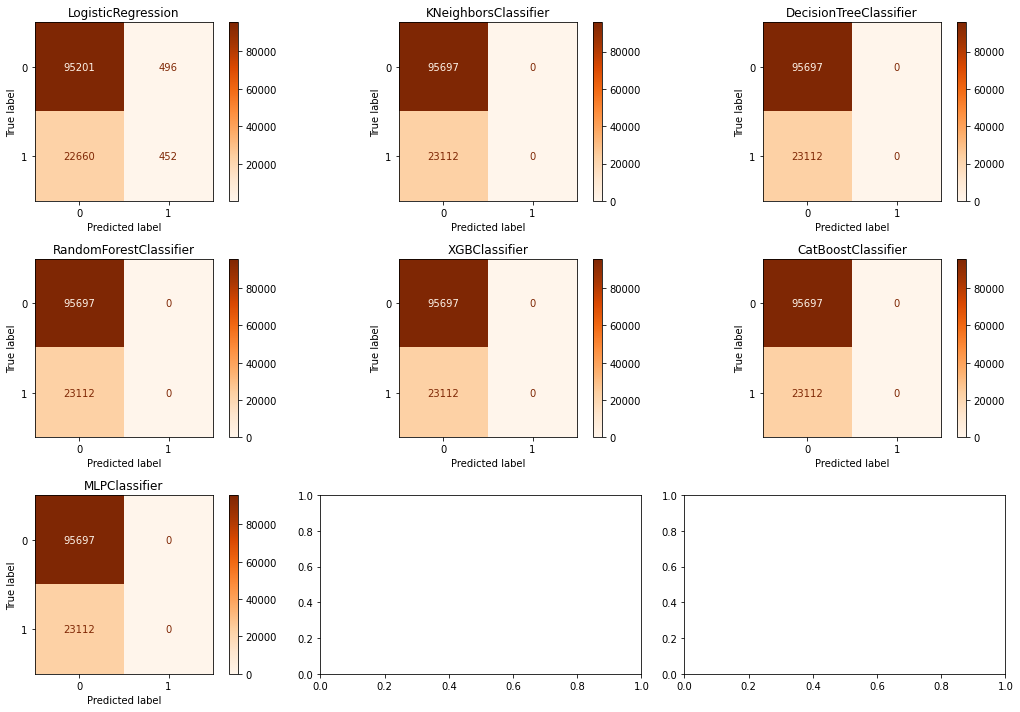

In [159]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15,10))

for cls, ax in zip(list(classifiers.values()), axes.flatten()):
    plot_confusion_matrix(cls, 
                          X_test[selected_features], 
                          y_test, 
                          ax=ax, 
                          cmap='Oranges')
    ax.title.set_text(type(cls).__name__)
plt.tight_layout()  
plt.show()

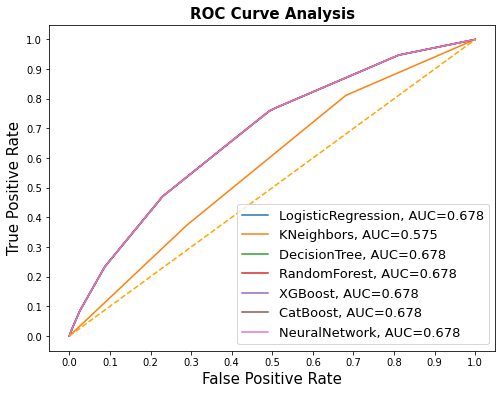

In [160]:
fig = plt.figure(figsize=(8,6))

for i in result_table.index:
    plt.plot(result_table.loc[i]['fpr'], 
             result_table.loc[i]['tpr'], 
             label="{}, AUC={:.3f}".format(i, result_table.loc[i]['auc']))
    
plt.plot([0,1], [0,1], color='orange', linestyle='--')

plt.xticks(np.arange(0.0, 1.1, step=0.1))
plt.xlabel("False Positive Rate", fontsize=15)

plt.yticks(np.arange(0.0, 1.1, step=0.1))
plt.ylabel("True Positive Rate", fontsize=15)

plt.title('ROC Curve Analysis', fontweight='bold', fontsize=15)
plt.legend(prop={'size':13}, loc='lower right')

plt.show()

In [161]:
result_table.iloc[:,:4]

,accuracy,presicion,recall,f1_score
classifiers,,,,
LogisticRegression,0.81,0.74,0.81,0.73
KNeighbors,0.81,0.65,0.81,0.72
DecisionTree,0.81,0.65,0.81,0.72
RandomForest,0.81,0.65,0.81,0.72
XGBoost,0.81,0.65,0.81,0.72
CatBoost,0.81,0.65,0.81,0.72
NeuralNetwork,0.81,0.65,0.81,0.72
